In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import warnings, sys, os, random


SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [12]:
import sklearn
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("XGBoost:", xgb.__version__)


Python: 3.12.9
NumPy: 1.26.4
Pandas: 2.3.2
scikit-learn: 1.7.2
XGBoost: 3.0.1


In [ ]:
from sklearn.datasets import load_diabetes
dataset = load_diabetes()

X = dataset.data
y = dataset.target

df = pd.DataFrame(X, columns=dataset.feature_names)
df["target"] = y

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [9]:
# Step 2: Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=["target"])
y = df["target"]

# Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 353
Testing samples: 89


In [10]:
# Step 3: Train an XGBoost regression model
from xgboost import XGBRegressor

# Initialize the model with some safe default parameters
xgb_model = XGBRegressor(
    n_estimators=200,      # number of boosting rounds (trees)
    learning_rate=0.1,     # step size shrinkage
    max_depth=4,           # maximum tree depth
    subsample=0.8,         # fraction of samples used per tree
    colsample_bytree=0.8,  # fraction of features used per tree
    random_state=42,       # reproducibility
    n_jobs=-1              # use all CPU cores
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")


RMSE: 56.685
MAE:  45.477
R²:   0.394


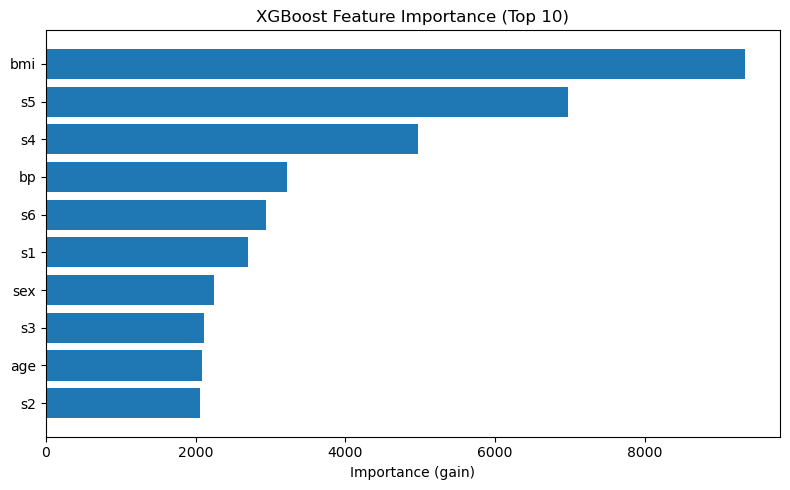

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance as a dict: {f0: score, f1: score, ...}
booster = xgb_model.get_booster()

# You can choose: 'gain' (recommended), 'weight', 'cover', 'total_gain', 'total_cover'
score = booster.get_score(importance_type='gain')

# Map back to original column names
feature_names = X_train.columns.tolist()
name_map = {f"f{i}": name for i, name in enumerate(feature_names)}
named_scores = {name_map.get(k, k): v for k, v in score.items()}

# Sort by importance
items = sorted(named_scores.items(), key=lambda x: x[1], reverse=True)

# Plot top 10 (or fewer if features < 10)
top_k = min(10, len(items))
labels, values = zip(*items[:top_k])

plt.figure(figsize=(8, 5))
y_pos = np.arange(top_k)
plt.barh(y_pos, values)
plt.yticks(y_pos, labels)
plt.gca().invert_yaxis()
plt.xlabel("Importance (gain)")
plt.title("XGBoost Feature Importance (Top 10)")
plt.tight_layout()
plt.show()


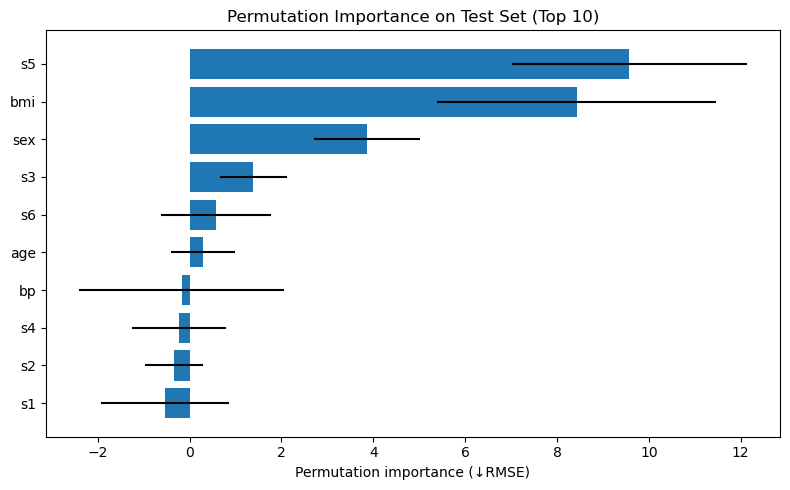

In [16]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    xgb_model, X_test, y_test,
    n_repeats=10, random_state=42, scoring="neg_root_mean_squared_error"
)

pi_mean = result.importances_mean
pi_std = result.importances_std

# Sort
idx = np.argsort(pi_mean)[::-1]
top_k = min(10, len(idx))
idx = idx[:top_k]

plt.figure(figsize=(8,5))
plt.barh(range(top_k), pi_mean[idx], xerr=pi_std[idx])
plt.yticks(range(top_k), X_test.columns[idx])
plt.gca().invert_yaxis()
plt.xlabel("Permutation importance (↓RMSE)")
plt.title("Permutation Importance on Test Set (Top 10)")
plt.tight_layout()
plt.show()
